**Contents:**

*  [Section 0: Custom Functions Created](#scrollTo=02amEA_KgZz8)
*  [Section 1: Analysing basic metrics and preprocessing of data](#scrollTo=D6Er27ybgw7U)
*  [Section 2: Exploratory Data Analysis](#scrollTo=RtLluPsGANVF)
*  [Section 3: Content Based Recommender Systems](#scrollTo=_ro3MJrtKNNR)
    1.   [Section 3.1 : Using Pearson Correlation - Movie related Movie suggestions](#scrollTo=FzbRh_sA37OR)
    2.   [Section 3.2: Using Cosine Similarity-Movie related Movie suggestions](#scrollTo=zuDraTt_Ezkb)
    3.   [Section 3.3 : Using Nearest Neighbors algorithm and Cosine Similarity-Movie related Movie suggestions](#scrollTo=RjRE4XnmXULo)
    4.   [Section 3.4 : Using Movie/Item Similarity matrix constructed with pearson coefficient-Movie related Movie suggestions](#scrollTo=PpFMitM1HG2C)
    5.   [Section 3.5 : Using User Similarity matrix constructed with pearson coefficient-User related user identified and get movie suggestions](#scrollTo=ew7E6_sUP3k2)
    6.   [Section 3.6 : Using Cosine Similarity-User related user identified and get movie suggestions](#scrollTo=uRsqdAkNDk0-)
*  [Section 4: Collaborative filtering based recommender systems](#scrollTo=Q7J4DNvEW9ph)

    1.   [Section 4.1 : Using Matrix Factorization - User related user identified and get movie suggestions](#scrollTo=BlimfoJYkMCy)
    2.   [Section 4.2: User Embedding features are used to create user-user similarity to find similar users and get recommendations](#scrollTo=UQjxpplZfLx1)
    3.   [Section 4.3: Movie Embedding features are used to create item-item similarity to find similar movies as recommendations](#scrollTo=YKklUlyIVUBM)
*  [Section 5: Insights and Recommendations](#scrollTo=ybiEw0OMW2ds)


In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install cmfrec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.6/267.6 KB 14.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.20-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.0.post1-cp38-cp38-linux_x86_64.whl size=6082739 sha256=6deae5e9293a09a0ecd32a9f7e6ead1a9b09c7b2a40a4489d56a3ba545e3d85f
  Stored in directory: /root/.cache/pip/wheels/08/6b/25/1ebcd3aad4d02fb6f68d9b045cf9bb019d0d94c261eb8c6758
Successfully built cmfrec


# Section 0: Custom Functions Created

Function created to show outliers and return clearing them : column wise detection(only 1 axis)

In [ ]:
def showBoxPlotWithOutliersAndMaxAndMinCapsFor1Axis(tempdf,columnnameToDescribeAsX):
  plt.figure(figsize=(5,5))  
  ax=sns.boxplot(x=columnnameToDescribeAsX,data=tempdf)
  alllabels=[]
  #calculating IQR and MIn and Max caps
  valdict=tempdf.loc[:,columnnameToDescribeAsX].describe().to_dict()
  IQR=valdict['75%']-valdict['25%']
  medianval=valdict['50%']
  meanval=valdict['mean']
  BoxplotMinCap=valdict['25%']-(1.5*IQR)
  if BoxplotMinCap<0: BoxplotMinCap=0.0
  BoxplotMaxCap=valdict['75%']+(1.5*IQR)
  alllabels.extend([columnnameToDescribeAsX+" Mean Val: "+str(meanval),columnnameToDescribeAsX+" Median Val: "+str(medianval),columnnameToDescribeAsX+" Min Cap: "+str(BoxplotMinCap),columnnameToDescribeAsX+" Max Cap: "+str(BoxplotMaxCap)])
  box = ax.get_position()
  ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
  # to Put a legend below current axis
  plt.legend(loc='upper center', bbox_to_anchor=(0.75, -0.15),fancybox=True, shadow=True, ncol=4,labels=alllabels,handlelength=0)
  #plt.legend(labels=alllabels,bbox_to_anchor=(1.25, 1),loc='upper center')
  plt.show()
  tempdfWithoutOutLiers=tempdf.loc[(tempdf[columnnameToDescribeAsX]>=BoxplotMinCap)&(tempdf[columnnameToDescribeAsX]<=BoxplotMaxCap)]
  return tempdfWithoutOutLiers

Function created to detect Outliers and remove them(2 features)

In [ ]:
def showBoxPlotWithOutliersAndMaxAndMinCaps(tempdf,columnnameToDescribeAsX,columnnameToDescribeAsY):
  plt.figure(figsize=(10,10))  
  allYvalues= tempdf[columnnameToDescribeAsX].unique().tolist()
  ax=sns.boxplot(x=columnnameToDescribeAsX,data=tempdf,y=columnnameToDescribeAsY)
  alllabels=[]
  tempdfWithoutOutLiers=tempdf.copy()
  blnfirst=True
  for echY in allYvalues:
    #calculating IQR and MIn and Max caps
    valdict=tempdf.loc[tempdf[columnnameToDescribeAsX]==echY][columnnameToDescribeAsY].describe().to_dict()
    IQR=valdict['75%']-valdict['25%']
    medianval=valdict['50%']
    meanval=valdict['mean']
    BoxplotMinCap=valdict['25%']-(1.5*IQR)
    BoxplotMaxCap=valdict['75%']+(1.5*IQR)
    if BoxplotMinCap<0: BoxplotMinCap=0.0
    if blnfirst==True:
      tempdfWithoutOutLiers=tempdf.loc[(tempdf[columnnameToDescribeAsX]==echY)&(tempdf[columnnameToDescribeAsY]>=BoxplotMinCap)&(tempdf[columnnameToDescribeAsY]<=BoxplotMaxCap)]
      blnfirst=False
    else:
      tempdfWithoutOutLiers=tempdfWithoutOutLiers.append(pd.DataFrame(tempdf.loc[(tempdf[columnnameToDescribeAsX]==echY)&(tempdf[columnnameToDescribeAsY]>=BoxplotMinCap)&(tempdf[columnnameToDescribeAsY]<=BoxplotMaxCap)]))
    #print([str(echY)+" Mean Val: "+str(meanval),str(echY)+" Median Val: "+str(medianval),str(echY)+" Min Cap: "+str(BoxplotMinCap),str(echY)+" Max Cap: "+str(BoxplotMaxCap)])
    alllabels.extend([str(echY)+" Mean Val: "+str(meanval),str(echY)+" Median Val: "+str(medianval),str(echY)+" Min Cap: "+str(BoxplotMinCap),str(echY)+" Max Cap: "+str(BoxplotMaxCap)])
  box = ax.get_position()
  ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
  # to Put a legend below current axis
  plt.legend(loc='upper center', bbox_to_anchor=(0.75, -0.15),fancybox=True, shadow=True, ncol=4,labels=alllabels,handlelength=0)
  #plt.legend(labels=alllabels,bbox_to_anchor=(1.25, 1),loc='upper center')
  plt.show()
  return tempdfWithoutOutLiers

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import math
from scipy.stats import skew
from scipy.stats import boxcox
from matplotlib import pylab, mlab, pyplot
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import plotly.graph_objects as go
import requests
import time
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
from scipy import stats

In [ ]:
moviesdf=pd.read_fwf(r'/content/drive/MyDrive/Scaler/OTT_casestudy/Data/movies.dat',encoding='ISO-8859-1')

In [ ]:
ratingsdf=pd.read_fwf(r'/content/drive/MyDrive/Scaler/OTT_casestudy/Data/ratings.dat',encoding='ISO-8859-1')

In [ ]:
usersdf=pd.read_fwf(r'/content/drive/MyDrive/Scaler/OTT_casestudy/Data/users.dat',encoding='ISO-8859-1')

**Problem Statement:** 
Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

# Section 1: Analysing basic metrics and preprocessing of data

In [ ]:
def rightSideCharreplace(s, old, new, occurrence):
  li = s.rsplit(old, occurrence)
  return new.join(li)

In [ ]:
moviesdf.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [ ]:
#cleaning columns in dataframe
moviesdf.columns=moviesdf.columns[0].split('::')

In [ ]:
moviesdf[moviesdf.columns] = moviesdf['Movie ID'].str.split("::", expand = True)
moviesdf['Title']=moviesdf['Title'].apply(lambda eachvalInColumn: rightSideCharreplace(eachvalInColumn,'(','##',1))

In [ ]:
moviesdf[['Title','Release Year']] = moviesdf['Title'].str.split("##", expand = True,n=1)
moviesdf['Release Year']=moviesdf['Release Year'].str.replace(')',"")
moviesdf[moviesdf.columns] = moviesdf.apply(lambda eachvalInColumn: eachvalInColumn.str.strip())

In [ ]:
moviesdf

,Movie ID,Title,Genres,Release Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000
3879,3949,Requiem for a Dream,Drama,2000
3880,3950,Tigerland,Drama,2000
3881,3951,Two Family House,Drama,2000


In [ ]:
moviesdf.shape

(3883, 4)

In [ ]:
moviesdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Movie ID      3883 non-null   object
 1   Title         3883 non-null   object
 2   Genres        3858 non-null   object
 3   Release Year  3881 non-null   object
dtypes: object(4)
memory usage: 121.5+ KB


In [ ]:
moviesdf.describe()

,Movie ID,Title,Genres,Release Year
count,3883,3883,3858,3881
unique,3883,3841,360,95
top,1,Hamlet,Drama,1996
freq,1,5,830,344


In [ ]:
moviesdf.loc[moviesdf['Release Year'].str.len()>4]

,Movie ID,Title,Genres,Release Year
197,199,"Umbrellas of Cherbourg, The (Parapluies de Che...",None,1964:
359,363,"Wonderful, Horrible Life of Leni Riefenstahl, The",None,Die Macht der B
720,729,"Institute Benjamenta, or This Dream People Cal...",None,1995:
783,793,My Life and Times With Antonin Artaud,None,En compagnie d'Antonin Arta
787,797,"Old Lady Who Walked in the Sea, The",None,Vieille qui marchait dans la
2170,2239,Swept Away,None,Travolti da un insolito destino nell'azzurro m...
2516,2585,"Lovers of the Arctic Circle, The",None,Los Amantes del Círculo Polar
2721,2790,"Final Conflict, The (a.k.a. Omen III: The Fina...",None,1981:
3567,3636,Those Who Love Me Can Take the Train,None,Ceux qui m'aiment prendront
3626,3695,Toxic Avenger Part III: The Last Temptation of...,None,1989:


**Insight: Removing these rows which are not parsed properly from data file**

In [ ]:
moviesdf=moviesdf.loc[moviesdf['Release Year'].str.len()==4]

In [ ]:
moviesdf.isna().sum()/moviesdf.shape[0]

Movie ID        0.000000
Title           0.000000
Genres          0.001553
Release Year    0.000000
dtype: float64

In [ ]:
moviesdf.isna().sum()

Movie ID        0
Title           0
Genres          6
Release Year    0
dtype: int64

**Missing values exist in columns: Genres**

In [ ]:
moviesdf.loc[moviesdf['Genres'].isna()]

,Movie ID,Title,Genres,Release Year
464,468,"Englishman Who Went Up a Hill, But Came Down a...",None,1995
1134,1150,"Return of Martin Guerre, The (Retour de Martin...",None,1982
1160,1176,"Double Life of Veronique, The (La Double Vie d...",None,1991
2522,2591,Jeanne and the Perfect Guy (Jeanne et le garço...,None,1998
2563,2632,"Saragossa Manuscript, The (Rekopis znaleziony ...",None,1965
3001,3070,Adventures of Buckaroo Bonzai Across the 8th D...,None,1984


In [ ]:
# replacing them with new genre called 'Other'
moviesdf['Genres']=moviesdf['Genres'].fillna('Other')
moviesdf['Genres']=moviesdf['Genres'].str.replace(' ','Other')
moviesdf.isna().sum()

Movie ID        0
Title           0
Genres          0
Release Year    0
dtype: int64

**All Missing values are cleaned up in movies dataframe**

In [ ]:
moviesdf['Genres']=moviesdf['Genres'].str.lower()

In [ ]:
moviesdf['Genres'] = moviesdf['Genres'].str.split('|')
moviesdf = moviesdf.explode('Genres')

In [ ]:
moviesdf['Genres'].value_counts()

drama       1576
comedy      1184
action       500
thriller     484
romance      453
            ... 
childr         1
music          1
wester         1
chil           1
horr           1
Name: Genres, Length: 64, dtype: int64

In [ ]:
genresProvidedAsValid=["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
genresProvidedAsValid=[x.lower() for x in genresProvidedAsValid]

In [ ]:
def funcToCheckProperGenre(val):
  val=val.strip()
  if val in genresProvidedAsValid:
    return val
  for eachval in genresProvidedAsValid:
    if val in eachval[0:len(val)]:
      return eachval
  return 'other'

In [ ]:
moviesdf['Genres']=moviesdf['Genres'].apply(lambda eachvalofcolumn: funcToCheckProperGenre(eachvalofcolumn))

In [ ]:
moviesdf['Genres'].value_counts()

drama          1582
comedy         1189
action          511
thriller        488
romance         462
horror          340
adventure       282
sci-fi          265
children's      249
crime           210
war             139
documentary     127
musical         113
mystery         105
animation       104
western          68
fantasy          63
film-noir        44
other             6
Name: Genres, dtype: int64

In [ ]:
moviesdf

,Movie ID,Title,Genres,Release Year
0,1,Toy Story,animation,1995
0,1,Toy Story,children's,1995
0,1,Toy Story,comedy,1995
1,2,Jumanji,adventure,1995
1,2,Jumanji,children's,1995
...,...,...,...,...
3879,3949,Requiem for a Dream,drama,2000
3880,3950,Tigerland,drama,2000
3881,3951,Two Family House,drama,2000
3882,3952,"Contender, The",drama,2000


In [ ]:
moviesdf['Movie ID'].value_counts()

70      5
1264    5
2081    5
2080    5
558     5
       ..
2390    1
824     1
826     1
2386    1
2702    1
Name: Movie ID, Length: 3864, dtype: int64

In [ ]:
# need to check why duplicates created because of some spl chars in data
duplicate = moviesdf[moviesdf.duplicated()]
duplicate

,Movie ID,Title,Genres,Release Year
1187,1205,"Transformers: The Movie, The",action,1986
2931,3000,"Princess Mononoke, The (Mononoke Hime)",action,1997
3794,3864,Godzilla 2000 (Gojira ni-sen mireniamu),action,1999


In [ ]:
moviesdf.drop_duplicates(keep='first',inplace=True)

In [ ]:
moviematrixtemp=moviesdf.copy()
moviematrixtemp = moviematrixtemp.pivot(index='Movie ID',columns='Genres', values='Title')
moviematrixtemp = ~moviematrixtemp.isna()
moviematrixtemp = moviematrixtemp.astype(int)
moviematrixtemp=moviematrixtemp.reset_index()

In [ ]:
moviesdf = pd.merge(moviesdf, moviematrixtemp,  how='left', left_on=['Movie ID'], right_on = ['Movie ID'])
moviesdf.drop(columns=['Genres'],inplace=True)
moviesdf.drop_duplicates(keep='first',inplace=True)
moviesdf=moviesdf.reset_index()


In [ ]:
moviesdf.drop(columns=['index'],inplace=True)
moviesdf

,Movie ID,Title,Release Year,action,adventure,animation,children's,comedy,crime,documentary,...,film-noir,horror,musical,mystery,other,romance,sci-fi,thriller,war,western
0,1,Toy Story,1995,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3859,3948,Meet the Parents,2000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3860,3949,Requiem for a Dream,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3861,3950,Tigerland,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3862,3951,Two Family House,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratingsdf.head(10)

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291
5,1::1197::3::978302268
6,1::1287::5::978302039
7,1::2804::5::978300719
8,1::594::4::978302268
9,1::919::4::978301368


In [ ]:
ratingstempdf=pd.DataFrame(data=ratingsdf.iloc[:,0].str.split("::", expand = True))
ratingstempdf.columns=ratingsdf.columns[0].split('::')
ratingsdf=ratingstempdf

In [ ]:
ratingsdf.shape

(1000209, 4)

In [ ]:
ratingsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [ ]:
ratingsdf.describe()

,UserID,MovieID,Rating,Timestamp
count,1000209,1000209,1000209,1000209
unique,6040,3706,5,458455
top,4169,2858,4,975528402
freq,2314,3428,348971,30


In [ ]:
ratingsdf.isna().sum()/ratingsdf.shape[0]

UserID       0.0
MovieID      0.0
Rating       0.0
Timestamp    0.0
dtype: float64

**No Missing values exist in any columns**

**movie wise avg rating by all users - need to be created as new feature**

In [ ]:
ratingsdf['Rating'] = ratingsdf['Rating'].astype('int64')

In [ ]:
ratingsdf.loc[(ratingsdf['MovieID']=='1')]['Rating'].value_counts()

4    835
5    820
3    345
2     61
1     16
Name: Rating, dtype: int64

In [ ]:
tempdf=ratingsdf.groupby('MovieID')['Rating'].agg(['count','mean']).reset_index().round(3)
ratingsdf = pd.merge(ratingsdf, tempdf,  how='left', left_on=['MovieID'], right_on = ['MovieID'])
ratingsdf.rename(columns={"count": "MovieViewCount", "mean": "MovieAvgRating"},inplace=True)

**User wise avg rating need to be created**

In [ ]:
tempdf=ratingsdf.groupby('UserID')['Rating'].agg(['count','mean']).reset_index().round(3)
ratingsdf = pd.merge(ratingsdf, tempdf,  how='left', left_on=['UserID'], right_on = ['UserID'])
ratingsdf.rename(columns={"count": "UserViewCount", "mean": "UserAvgRating"},inplace=True)

In [ ]:
ratingsdf

,UserID,MovieID,Rating,Timestamp,MovieViewCount,MovieAvgRating,UserViewCount,UserAvgRating
0,1,1193,5,978300760,1725,4.391,53,4.189
1,1,661,3,978302109,525,3.465,53,4.189
2,1,914,3,978301968,636,4.154,53,4.189
3,1,3408,4,978300275,1315,3.864,53,4.189
4,1,2355,5,978824291,1703,3.854,53,4.189
...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,373,2.794,341,3.578
1000205,6040,1094,5,956704887,1229,3.731,341,3.578
1000206,6040,562,5,956704746,478,3.799,341,3.578
1000207,6040,1096,4,956715648,344,3.977,341,3.578


In [ ]:
usersdf

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455
...,...
6035,6036::F::25::15::32603
6036,6037::F::45::1::76006
6037,6038::F::56::1::14706
6038,6039::F::45::0::01060


In [ ]:
userstempdf=pd.DataFrame(data=usersdf.iloc[:,0].str.split("::", expand = True))
userstempdf.columns=usersdf.columns[0].split('::')
usersdf=userstempdf

In [ ]:
usersdf.shape

(6040, 5)

In [ ]:
usersdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [ ]:
usersdf.describe()

,UserID,Gender,Age,Occupation,Zip-code
count,6040,6040,6040,6040,6040
unique,6040,2,7,21,3439
top,1,M,25,4,48104
freq,1,4331,2096,759,19


In [ ]:
usersdf.isna().sum()/usersdf.shape[0]

UserID        0.0
Gender        0.0
Age           0.0
Occupation    0.0
Zip-code      0.0
dtype: float64

**No Missing values exist in any columns**

In [ ]:
new_df = pd.merge(ratingsdf, usersdf,  how='left', left_on=['UserID'], right_on = ['UserID'])

In [ ]:
new_df

,UserID,MovieID,Rating,Timestamp,MovieViewCount,MovieAvgRating,UserViewCount,UserAvgRating,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,1725,4.391,53,4.189,F,1,10,48067
1,1,661,3,978302109,525,3.465,53,4.189,F,1,10,48067
2,1,914,3,978301968,636,4.154,53,4.189,F,1,10,48067
3,1,3408,4,978300275,1315,3.864,53,4.189,F,1,10,48067
4,1,2355,5,978824291,1703,3.854,53,4.189,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,373,2.794,341,3.578,M,25,6,11106
1000205,6040,1094,5,956704887,1229,3.731,341,3.578,M,25,6,11106
1000206,6040,562,5,956704746,478,3.799,341,3.578,M,25,6,11106
1000207,6040,1096,4,956715648,344,3.977,341,3.578,M,25,6,11106


In [ ]:
finaldf = pd.merge(new_df, moviesdf,  how='left', left_on=['MovieID'], right_on = ['Movie ID'])

In [ ]:
finaldf.drop(columns=['Movie ID'],inplace=True)

In [ ]:
finaldf=finaldf.loc[~finaldf['Title'].isna()]

In [ ]:
finaldf

,UserID,MovieID,Rating,Timestamp,MovieViewCount,MovieAvgRating,UserViewCount,UserAvgRating,Gender,Age,...,film-noir,horror,musical,mystery,other,romance,sci-fi,thriller,war,western
0,1,1193,5,978300760,1725,4.391,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,661,3,978302109,525,3.465,53,4.189,F,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,914,3,978301968,636,4.154,53,4.189,F,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,3408,4,978300275,1315,3.864,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2355,5,978824291,1703,3.854,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,373,2.794,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000205,6040,1094,5,956704887,1229,3.731,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1000206,6040,562,5,956704746,478,3.799,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000207,6040,1096,4,956715648,344,3.977,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 2: Exploratory Data Analysis

In [ ]:
finaldf.columns

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'MovieViewCount',
       'MovieAvgRating', 'UserViewCount', 'UserAvgRating', 'Gender', 'Age',
       'Occupation', 'Zip-code', 'Title', 'Release Year', 'action',
       'adventure', 'animation', 'children's', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical',
       'mystery', 'other', 'romance', 'sci-fi', 'thriller', 'war', 'western'],
      dtype='object')

**Univariant analysis on numerical features: to find outliers and other details using IQR method**

In [ ]:
numericalfeatures=["MovieViewCount","MovieAvgRating","UserViewCount",'UserAvgRating']

In [ ]:
categoricalfeatures=['Rating','Gender', 'Age','Occupation', 'Zip-code','Release Year']

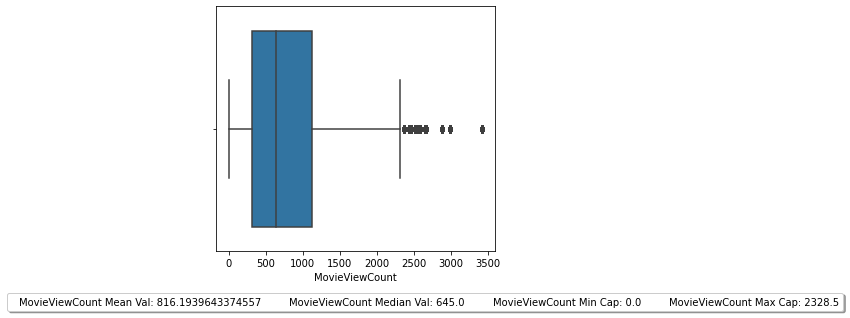

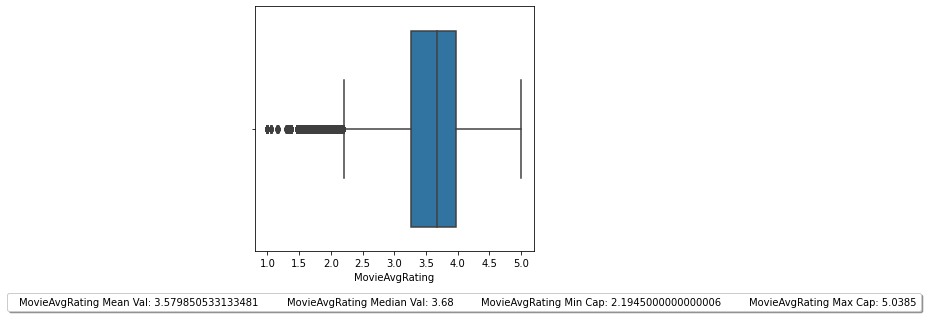

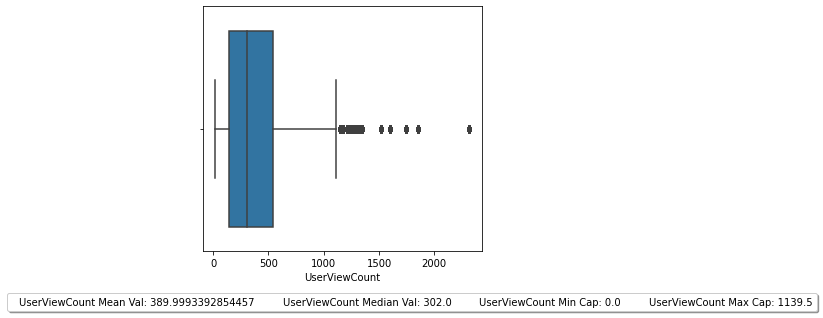

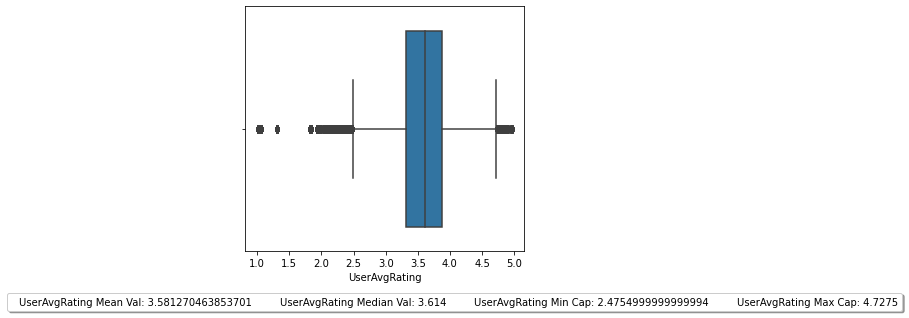

In [ ]:
for colname in numericalfeatures:
  showBoxPlotWithOutliersAndMaxAndMinCapsFor1Axis(finaldf,colname)

**Categorical variables - Univariant analysis**

-------------------Rating Analysis-------------------------
   Rating
4  348180
3  260856
5  224872
2  107420
1   56077


<Figure size 576x576 with 0 Axes>

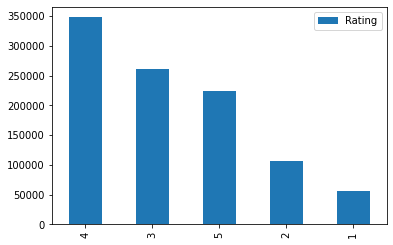

-------------------Gender Analysis-------------------------
   Gender
M  751500
F  245905


<Figure size 576x576 with 0 Axes>

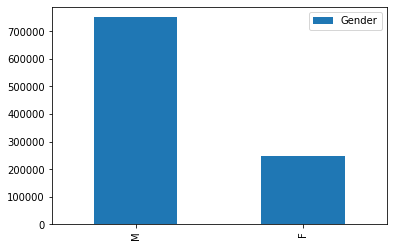

-------------------Age Analysis-------------------------
       Age
25  394623
35  198394
18  183154
45   83303
50   72188
56   38598
1    27145


<Figure size 576x576 with 0 Axes>

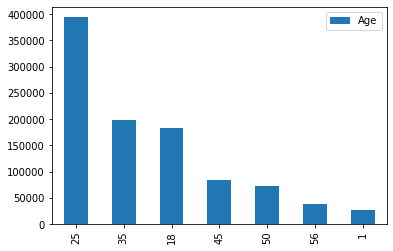

-------------------Occupation Analysis-------------------------
    Occupation
4       130726
0       130161
7       105146
1        85056
17       72635
20       60180
12       57035
2        49905
14       48999
16       45887
6        37098
3        31553
10       23244
15       22862
5        21800
11       20490
19       14861
13       13682
18       12062
9        11326
8         2697


<Figure size 576x576 with 0 Axes>

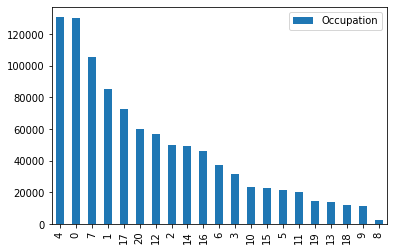

-------------------Zip-code Analysis-------------------------
       Zip-code
94110      3793
60640      3420
98103      3190
95616      3072
02138      3010
...         ...
90732        20
44122        20
36102        20
14706        20
58369        19

[3439 rows x 1 columns]


<Figure size 576x576 with 0 Axes>

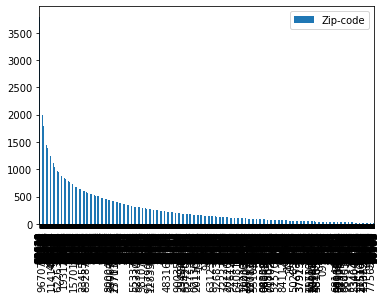

-------------------Release Year Analysis-------------------------
      Release Year
1999         86833
1998         68165
1997         65402
1995         60751
1996         59271
...            ...
1919            45
1929            43
1928            27
1920            24
1923            17

[81 rows x 1 columns]


<Figure size 576x576 with 0 Axes>

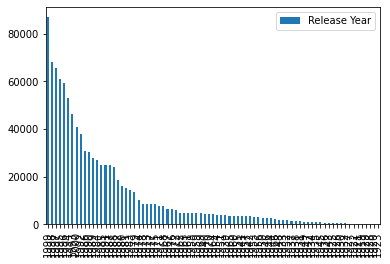

In [ ]:
for colname in categoricalfeatures:
  print("-------------------"+colname+" Analysis-------------------------")
  plt.figure(figsize=(8,8)) 
  print(pd.DataFrame(finaldf[colname].value_counts()))
  pd.DataFrame(finaldf[colname].value_counts()).plot(kind="bar")
  plt.xticks(rotation=90)
  plt.show()

**Insight:** Users of which age group have watched and rated the most number of movies? - 25 Age group : "25-34"

**Insight:** Users belonging to which profession have watched and rated the most movies? - Occupation 4: "college/grad student"

**Insight:** Most of the users in our dataset who’ve rated the movies are Male? - Yes

**Insight:** Most of the movies present in our dataset were released in which decade? - 90s decade

**Categorical Features - Bivariant analysis**

In [ ]:
genresColumns=['action',
       'adventure', 'animation', "children's", 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical',
       'mystery', 'other', 'romance', 'sci-fi', 'thriller', 'war', 'western']

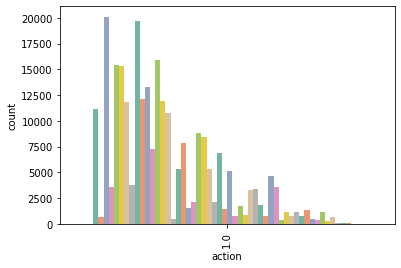

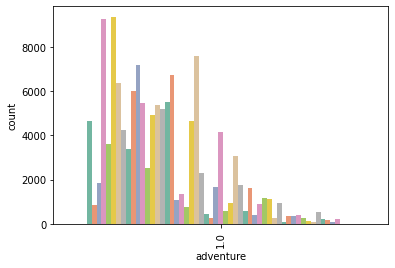

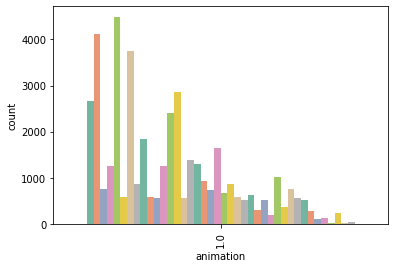

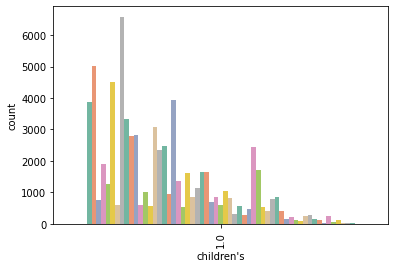

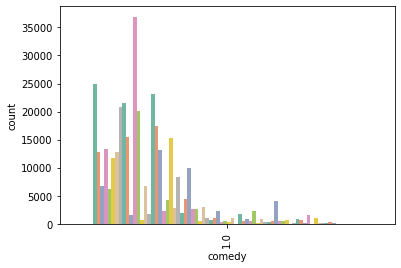

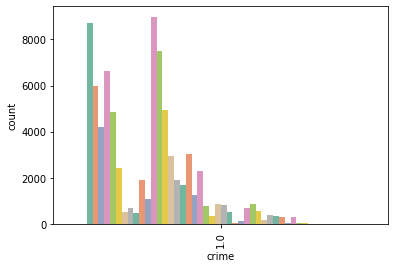

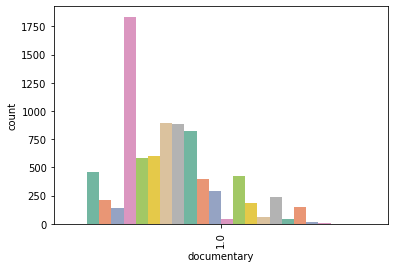

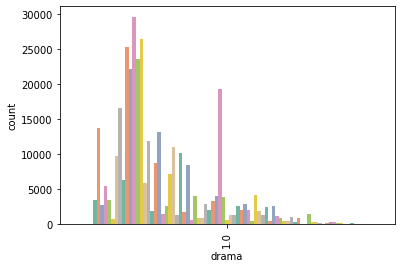

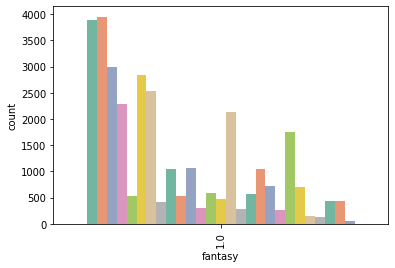

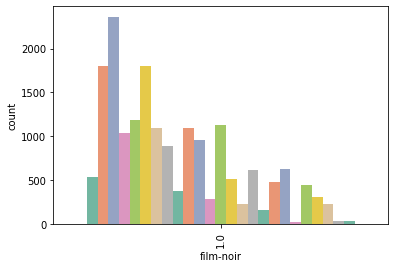

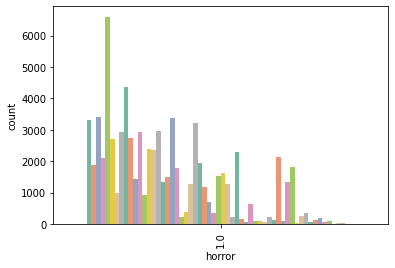

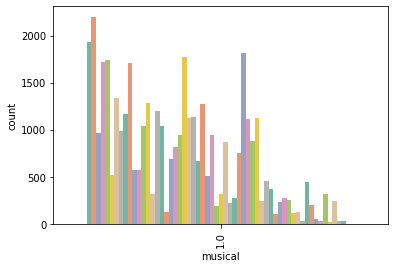

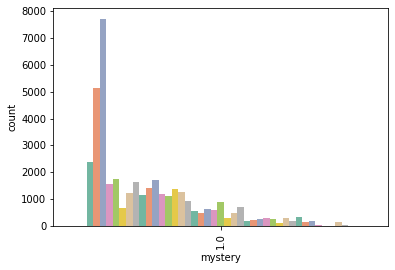

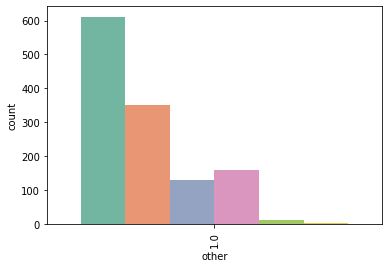

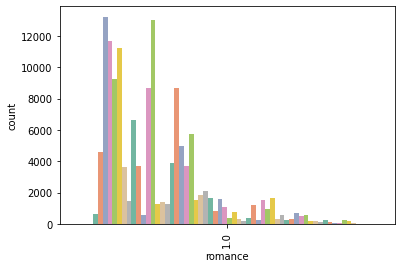

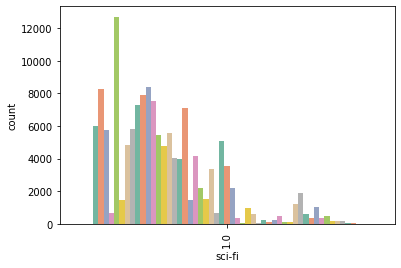

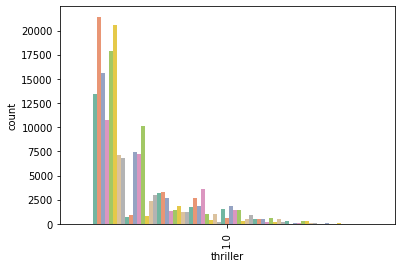

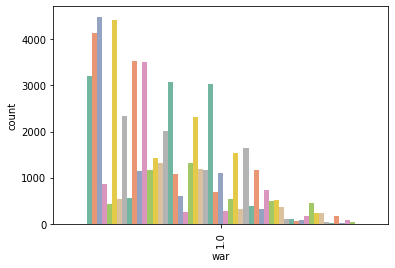

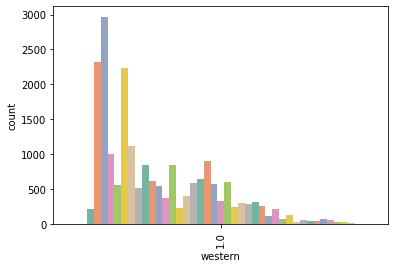

In [ ]:
from scipy.stats.morestats import sort
for colname in genresColumns:
  sns.countplot(x=colname,data=finaldf.loc[(finaldf[colname]==1)],hue="Release Year",palette="Set2")
  plt.xticks(rotation=90)
  plt.legend([],[], frameon=False)
  plt.show()

In [ ]:
for colname in genresColumns:
  print('---------------------'+colname+' Analysis year by year-------------------')
  print(pd.DataFrame(data=finaldf.loc[(finaldf[colname]==1)][[colname,"Release Year"]].groupby(by=["Release Year"]).sum(),columns=[colname]).reset_index().sort_values(by=colname,ascending=False))

---------------------action Analysis year by year-------------------
   Release Year   action
49         1998  20111.0
48         1997  19700.0
46         1995  15886.0
47         1996  15451.0
50         1999  15368.0
44         1993  13303.0
51         2000  12124.0
45         1994  11930.0
41         1990  11873.0
38         1987  11199.0
43         1992  10751.0
37         1986   8787.0
40         1989   8425.0
32         1981   7865.0
42         1991   7260.0
35         1984   6844.0
31         1980   5346.0
39         1988   5332.0
30         1979   5112.0
33         1982   4616.0
34         1983   3733.0
28         1977   3584.0
36         1985   3583.0
25         1974   3375.0
23         1972   3247.0
27         1976   2162.0
20         1969   2093.0
29         1978   1808.0
26         1975   1697.0
22         1971   1561.0
15         1964   1419.0
24         1973   1400.0
13         1962   1203.0
19         1968   1162.0
6          1951   1162.0
17         1966    822.0
8     

In [ ]:
for colname in genresColumns:
  print('---------------------'+colname+' Analysis by Age group-------------------')
  print(pd.DataFrame(data=finaldf.loc[(finaldf[colname]==1)][[colname,"Age"]].groupby(by=["Age"]).count(),columns=[colname]).reset_index().sort_values(by=colname,ascending=False))

---------------------action Analysis by Age group-------------------
  Age  action
2  25  105921
3  35   50615
1  18   50322
4  45   19397
5  50   17038
6  56    8174
0   1    6624
---------------------adventure Analysis by Age group-------------------
  Age  adventure
2  25      52358
3  35      26517
1  18      26280
4  45      10674
5  50       9044
6  56       4476
0   1       3993
---------------------animation Analysis by Age group-------------------
  Age  animation
2  25      16302
1  18      10165
3  35       8077
4  45       2876
0   1       2427
5  50       2023
6  56       1078
---------------------children's Analysis by Age group-------------------
  Age  children's
2  25       25655
1  18       16792
3  35       13966
4  45        5389
0   1        4319
5  50        3879
6  56        1887
---------------------comedy Analysis by Age group-------------------
  Age  comedy
2  25  142052
1  18   69432
3  35   68586
4  45   27635
5  50   22937
6  56   11881
0   1   11032
-----

In [ ]:
for colname in genresColumns:
  print('---------------------'+colname+' Analysis by Gender-------------------')
  print(pd.DataFrame(data=finaldf.loc[(finaldf[colname]==1)][[colname,"Gender"]].groupby(by=["Gender"]).sum(),columns=[colname]).reset_index().sort_values(by=colname,ascending=False))

---------------------action Analysis by Gender-------------------
  Gender    action
1      M  212065.0
0      F   46026.0
---------------------adventure Analysis by Gender-------------------
  Gender  adventure
1      M   106104.0
0      F    27238.0
---------------------animation Analysis by Gender-------------------
  Gender  animation
1      M    30791.0
0      F    12157.0
---------------------children's Analysis by Gender-------------------
  Gender  children's
1      M     50632.0
0      F     21255.0
---------------------comedy Analysis by Gender-------------------
  Gender    comedy
1      M  258038.0
0      F   95517.0
---------------------crime Analysis by Gender-------------------
  Gender    crime
1      M  62969.0
0      F  16418.0
---------------------documentary Analysis by Gender-------------------
  Gender  documentary
1      M       6191.0
0      F       2099.0
---------------------drama Analysis by Gender-------------------
  Gender     drama
1      M  252628.0
0   

In [ ]:
for colname in genresColumns:
  print('---------------------'+colname+' Analysis by Gender-F -------------------')
  print(pd.DataFrame(data=finaldf.loc[(finaldf[colname]==1)&(finaldf["Gender"]=='F')][[colname,"Gender"]].groupby(by=["Gender"]).sum(),columns=[colname]).reset_index().sort_values(by=colname,ascending=False))

---------------------action Analysis by Gender-F -------------------
  Gender   action
0      F  46026.0
---------------------adventure Analysis by Gender-F -------------------
  Gender  adventure
0      F    27238.0
---------------------animation Analysis by Gender-F -------------------
  Gender  animation
0      F    12157.0
---------------------children's Analysis by Gender-F -------------------
  Gender  children's
0      F     21255.0
---------------------comedy Analysis by Gender-F -------------------
  Gender   comedy
0      F  95517.0
---------------------crime Analysis by Gender-F -------------------
  Gender    crime
0      F  16418.0
---------------------documentary Analysis by Gender-F -------------------
  Gender  documentary
0      F       2099.0
---------------------drama Analysis by Gender-F -------------------
  Gender    drama
0      F  96937.0
---------------------fantasy Analysis by Gender-F -------------------
  Gender  fantasy
0      F   7769.0
-------------------

**Insight:** Most female users watched Comedy and Drama genre related movies.

In [ ]:
for colname in genresColumns:
  print('---------------------'+colname+' Analysis by Rating Average-------------------')
  print(finaldf.loc[(finaldf[colname]==1)]['Rating'].mean())

---------------------action Analysis by Rating Average-------------------
3.488831458671554
---------------------adventure Analysis by Rating Average-------------------
3.4776664516806406
---------------------animation Analysis by Rating Average-------------------
3.681149296824066
---------------------children's Analysis by Rating Average-------------------
3.4273651703367785
---------------------comedy Analysis by Rating Average-------------------
3.5227107522167698
---------------------crime Analysis by Rating Average-------------------
3.7087810346782217
---------------------documentary Analysis by Rating Average-------------------
3.9211097708082026
---------------------drama Analysis by Rating Average-------------------
3.7603564430077383
---------------------fantasy Analysis by Rating Average-------------------
3.453677796431014
---------------------film-noir Analysis by Rating Average-------------------
4.075187558184108
---------------------horror Analysis by Rating Average---

**Insight:** film-noir and documentary genre has highest average rating

**Movies versus No of ratings**

In [ ]:
finaldf.groupby(['Title'])['Rating'].agg('count').reset_index().sort_values(by='Rating',ascending=False)

,Title,Rating
126,American Beauty,3428
3105,Star Wars: Episode IV - A New Hope,2991
3106,Star Wars: Episode V - The Empire Strikes Back,2990
3107,Star Wars: Episode VI - Return of the Jedi,2883
1765,Jurassic Park,2672
...,...,...
3247,Terror in a Texas Town,1
1124,Fausto,1
3240,Ten Benny,1
3238,Telling You,1


**Insight:** The movie with maximum no. of ratings is ___. - American Beauty

In [ ]:
finaldf

,UserID,MovieID,Rating,Timestamp,MovieViewCount,MovieAvgRating,UserViewCount,UserAvgRating,Gender,Age,...,film-noir,horror,musical,mystery,other,romance,sci-fi,thriller,war,western
0,1,1193,5,978300760,1725,4.391,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,661,3,978302109,525,3.465,53,4.189,F,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,914,3,978301968,636,4.154,53,4.189,F,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,3408,4,978300275,1315,3.864,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2355,5,978824291,1703,3.854,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,373,2.794,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000205,6040,1094,5,956704887,1229,3.731,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1000206,6040,562,5,956704746,478,3.799,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000207,6040,1096,4,956715648,344,3.977,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 3: Content Based Recommender Systems

# Section 3.1 : Using Pearson Correlation - Movie related Movie suggestions

In [ ]:
movieandGenresDf=finaldf[['MovieID','Title','MovieViewCount','MovieAvgRating','action','adventure', 'animation', "children's", 'comedy', 'crime','documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical','mystery', 'other', 'romance', 'sci-fi', 'thriller', 'war', 'western']]

In [ ]:
movieandGenresDf.drop_duplicates(keep='first',inplace=True)

In [ ]:
from scipy import stats
def GetPearsonCoeeficientvalue(data1, data2):
  corrvalue, _ = stats.pearsonr(data1, data2)
  return corrvalue

In [ ]:
def getNRecommendedMoviesUsingPearsonCoeff(movieandGenresDf,movieTitle,RecommendationsCountRequired):
  # creation of ranks
  queryMovieId=movieandGenresDf.loc[(movieandGenresDf.Title==movieTitle)]['MovieID'].values[0]
  ranks = []
  querypoint=movieandGenresDf.loc[(movieandGenresDf.MovieID==queryMovieId)][movieandGenresDf.columns[2:]]
  for candidate in movieandGenresDf.MovieID:
      if str(candidate) == str(queryMovieId):
          continue
      candidatepoint=movieandGenresDf.loc[(movieandGenresDf.MovieID==candidate)][movieandGenresDf.columns[2:]]
      ranks.append([queryMovieId, candidate, GetPearsonCoeeficientvalue(querypoint.values[0], candidatepoint.values[0])])
  # creation of suggestions dataframe based on ranks created
  ranksdf = pd.DataFrame(ranks, columns=['query', 'candidate', 'CorrCoefficient'])
  ranksdf = ranksdf.merge(movieandGenresDf[['MovieID','Title']], left_on='query', right_on='MovieID').rename(columns={'Title': 'query_title'}).drop(columns=['MovieID'])
  ranksdf = ranksdf.merge(movieandGenresDf[['MovieID','Title']], left_on='candidate', right_on='MovieID').rename(columns={'Title': 'candidate_title'}).drop(columns=['MovieID'])
  ranksdf = ranksdf.sort_values(by=['query', 'CorrCoefficient'],ascending=False)
  return ranksdf.head(RecommendationsCountRequired)

In [ ]:
recommendationsDf=getNRecommendedMoviesUsingPearsonCoeff(movieandGenresDf,'Toy Story',5)

In [ ]:
recommendationsDf

,query,candidate,CorrCoefficient,query_title,candidate_title
4,1,2355,1.0,Toy Story,"Bug's Life, A"
183,1,2997,1.0,Toy Story,Being John Malkovich
49,1,3114,1.0,Toy Story,Toy Story 2
15,1,2791,1.0,Toy Story,Airplane!
380,1,34,1.0,Toy Story,Babe


In [ ]:
movieandGenresDf.loc[(movieandGenresDf.MovieID.isin(np.array(recommendationsDf.head().candidate.values))|(movieandGenresDf.MovieID.isin(['1'])))]

,MovieID,Title,MovieViewCount,MovieAvgRating,action,adventure,animation,children's,comedy,crime,...,film-noir,horror,musical,mystery,other,romance,sci-fi,thriller,war,western
4,2355,"Bug's Life, A",1703,3.854,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2791,Airplane!,1731,3.971,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,1,Toy Story,2077,4.147,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,3114,Toy Story 2,1585,4.219,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,2997,Being John Malkovich,2241,4.125,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,34,Babe,1751,3.891,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 3.2: Using Cosine Similarity-Movie related Movie suggestions

In [ ]:
def cosine_similarity(x, y):
    
    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return 0
    
    # Compute the dot product between x and y
    dot_product = np.dot(x, y)
    
    # Compute the L2 norms (magnitudes) of x and y
    magnitude_x = np.sqrt(np.sum(x**2)) 
    magnitude_y = np.sqrt(np.sum(y**2))
    
    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)
    
    return cosine_similarity

In [ ]:
from scipy.spatial import distance
def GetCosineDistanceValue(data1, data2):
  cosinedistance= distance.cosine(data1, data2)
  return cosinedistance

In [ ]:
def getNRecommendedMoviesUsingCosineSimilarity(movieandGenresDf,movieTitle,RecommendationsCountRequired):
  # creation of ranks
  queryMovieId=movieandGenresDf.loc[(movieandGenresDf.Title==movieTitle)]['MovieID'].values[0]
  ranks_cosine = []
  querypoint=movieandGenresDf.loc[(movieandGenresDf.MovieID==queryMovieId)][movieandGenresDf.columns[2:]]
  for candidate in movieandGenresDf.MovieID:
    if str(candidate) == str(queryMovieId):
        continue
    candidatepoint=movieandGenresDf.loc[(movieandGenresDf.MovieID==candidate)][movieandGenresDf.columns[2:]]
    ranks_cosine.append([queryMovieId, candidate, GetCosineDistanceValue(querypoint.values[0], candidatepoint.values[0])])

  # creation of suggestions dataframe based on ranks created
  ranksdf_cosine = pd.DataFrame(ranks_cosine, columns=['query', 'candidate', 'CosineDistance'])
  ranksdf_cosine = ranksdf_cosine.merge(movieandGenresDf[['MovieID','Title']], left_on='query', right_on='MovieID').rename(columns={'Title': 'query_title'}).drop(columns=['MovieID'])
  ranksdf_cosine = ranksdf_cosine.merge(movieandGenresDf[['MovieID','Title']], left_on='candidate', right_on='MovieID').rename(columns={'Title': 'candidate_title'}).drop(columns=['MovieID'])
  ranksdf_cosine = ranksdf_cosine.sort_values(by=['query', 'CosineDistance'],ascending=True)
  return ranksdf_cosine.head(RecommendationsCountRequired)

In [ ]:
recommendationsDf_cosine=getNRecommendedMoviesUsingCosineSimilarity(movieandGenresDf,'Toy Story',5)

In [ ]:
recommendationsDf_cosine

,query,candidate,CosineDistance,query_title,candidate_title
4,1,2355,5.226333e-08,Toy Story,"Bug's Life, A"
183,1,2997,2.445845e-07,Toy Story,Being John Malkovich
49,1,3114,2.547457e-07,Toy Story,Toy Story 2
15,1,2791,2.806658e-07,Toy Story,Airplane!
380,1,34,3.124474e-07,Toy Story,Babe


In [ ]:
movieandGenresDf.loc[(movieandGenresDf.MovieID.isin(np.array(recommendationsDf_cosine.head().candidate.values))|(movieandGenresDf.Title=='Toy Story'))]

,MovieID,Title,MovieViewCount,MovieAvgRating,action,adventure,animation,children's,comedy,crime,...,film-noir,horror,musical,mystery,other,romance,sci-fi,thriller,war,western
4,2355,"Bug's Life, A",1703,3.854,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2791,Airplane!,1731,3.971,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,1,Toy Story,2077,4.147,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,3114,Toy Story 2,1585,4.219,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,2997,Being John Malkovich,2241,4.125,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,34,Babe,1751,3.891,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Insight: Both Cosine similarity and Pearson correlation coefficient gave same result for query point**

 
**Insight**

Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.

Answer : Pearson Correlation : [-1,1]  -1 refers perfect negative correlation and 1 refers perfect positive correlation

Cosine Similarity: [0,1] '0' refers vectors are perpendicular,dissimilar vectors where as '1' refers that vectors are aligned perfectly with 0 degrees between them-similar vectors.


In [ ]:
recommendationsDf_cosine2=getNRecommendedMoviesUsingCosineSimilarity(movieandGenresDf,'Liar Liar',5)

In [ ]:
recommendationsDf_cosine2

,query,candidate,CosineDistance,query_title,candidate_title
867,1485,141,1.869159e-09,Liar Liar,"Birdcage, The"
886,1485,1883,3.377164e-09,Liar Liar,Bulworth
182,1485,3868,3.646148e-09,Liar Liar,"Naked Gun: From the Files of Police Squad!, The"
179,1485,104,4.246915e-09,Liar Liar,Happy Gilmore
1179,1485,2150,7.722690e-09,Liar Liar,"Gods Must Be Crazy, The"


**Insight:** Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

Birdcage, The

Bulworth

Naked Gun: From the Files of Police Squad!, The

Happy Gilmore

Gods Must Be Crazy, The

# Section 3.3 : Using Nearest Neighbors algorithm and Cosine Similarity-Movie related Movie suggestions

In [ ]:
from sklearn.neighbors import NearestNeighbors
def getNRecommendedMoviesUsingNearestNeighborsAlgoWithCosineMetric(movieandGenresDf,movieTitle,RecommendationsCountRequired):
  # fitting the model
  nbrs = NearestNeighbors(n_neighbors=RecommendationsCountRequired+1, algorithm='brute',metric='cosine',n_jobs=-1).fit(movieandGenresDf[movieandGenresDf.columns[2:]])
  distances, indices = nbrs.kneighbors(movieandGenresDf[movieandGenresDf.columns[2:]])

  # preparing consolidated dataframe of results
  indicescolumns=['queryIndex']
  distanceValColumns=['selfDist']
  for itr in range(1,RecommendationsCountRequired+1):
    indicescolumns.append('NeighrIndex_'+str(itr))
    distanceValColumns.append('DistValOfNgbr_'+str(itr))
  resultantdf=pd.DataFrame(data=indices,columns=indicescolumns)
  resultantdf[distanceValColumns]=distances

  # filtering required neighbours from entire resultant dataframe
  reqIndex=movieandGenresDf.loc[(movieandGenresDf['Title']==movieTitle)].index.values[0]
  neighbourindices=resultantdf.loc[(resultantdf['queryIndex']==reqIndex)][indicescolumns[1:]].values[0]
  return movieandGenresDf.iloc[neighbourindices]


In [ ]:
getNRecommendedMoviesUsingNearestNeighborsAlgoWithCosineMetric(movieandGenresDf,'Toy Story',5)

,MovieID,Title,MovieViewCount,MovieAvgRating,action,adventure,animation,children's,comedy,crime,...,film-noir,horror,musical,mystery,other,romance,sci-fi,thriller,war,western
4,2355,"Bug's Life, A",1703,3.854,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,2997,Being John Malkovich,2241,4.125,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,3114,Toy Story 2,1585,4.219,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2791,Airplane!,1731,3.971,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,34,Babe,1751,3.891,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Insight: Same result we achieved through Pearson coefficient method and Cosine Similarity method as well.**

# Section 3.4 : Using Movie/Item Similarity matrix constructed with pearson coefficient-Movie related Movie suggestions

In [ ]:
tempmatrixForItemSimilaritymatrix=pd.crosstab(finaldf['Title'],finaldf['UserID'],values = finaldf['Rating'],aggfunc='sum')
tempmatrixForItemSimilaritymatrix

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Night Mother,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The",NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Zed & Two Noughts, A",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zero Effect,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zero Kelvin (Kjærlighetens kjøtere),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Insight:**

**There are lot of null values in data,we cannot replace with 0 in null value places as 0 is the worst case scenario here as scale is from 0-5.**

**We need to use centred cosine method to solve this. This normalizes data such that average value will be 0 making it as non-least value.So we can fill nan values as 0.**

**This also solves easy rater and critic rater user values impact on all other ratings.**

In [ ]:
def getNRecommendedMoviesUsingSimilarityMatrixConstructedUsingRatings(tempmatrixForItemSimilaritymatrix,movieTitle,RecommendationsCountRequired):
  tempmatrixForItemSimilaritymatrix_normalized=tempmatrixForItemSimilaritymatrix.subtract(tempmatrixForItemSimilaritymatrix.mean(axis=1), axis = 0)
  tempmatrixForItemSimilaritymatrix_normalized.fillna(0,inplace=True)
  item_similarity_Matrix = tempmatrixForItemSimilaritymatrix_normalized.T.corr()
  FinalResultantdf=item_similarity_Matrix[[movieTitle]].reset_index()
  FinalResultantdf.columns=['Title','Correlation Coefficient']
  return FinalResultantdf.sort_values(by='Correlation Coefficient',ascending=False).head(RecommendationsCountRequired+1)

In [ ]:
getNRecommendedMoviesUsingSimilarityMatrixConstructedUsingRatings(tempmatrixForItemSimilaritymatrix,'Toy Story',5)

,Title,Correlation Coefficient
3357,Toy Story,1.000000
3358,Toy Story 2,0.359299
88,Aladdin,0.263130
555,"Bug's Life, A",0.241819
322,Beauty and the Beast,0.216925
1911,"Lion King, The",0.204845


**Insight: Ratings related similarity checks provided different set of recommendations.**

# Section 3.5 : Using User Similarity matrix constructed with pearson coefficient-User related user identified and get movie suggestions

In [ ]:
tempmatrixForUserSimilaritymatrix=pd.crosstab(finaldf['UserID'],finaldf['Title'],values = finaldf['Rating'],aggfunc='sum')
tempmatrixForUserSimilaritymatrix

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Insight:**

**There are lot of null values in data,we cannot replace with 0 in null value places as 0 is the worst case scenario here as scale is from 0-5.**

**We need to use centred cosine method to solve this. This normalizes data such that average value will be 0 making it as non-least value.So we can fill nan values as 0.**

**This also solves easy rater and critic rater user values impact on all other ratings.**

In [ ]:
def getNSimilarUsersUsingUserSimilarityMatrixConstructedUsingRatings(tempmatrixForUserSimilaritymatrix,queryUserId,RecommendationsCountRequired):
  tempmatrixForUserSimilaritymatrix_normalized=tempmatrixForUserSimilaritymatrix.subtract(tempmatrixForUserSimilaritymatrix.mean(axis=1), axis = 0)
  tempmatrixForUserSimilaritymatrix_normalized.fillna(0,inplace=True)
  user_similarity_Matrix = tempmatrixForUserSimilaritymatrix_normalized.T.corr()
  FinalResultantdf=user_similarity_Matrix[[str(queryUserId)]].reset_index()
  FinalResultantdf.columns=['UserID','Correlation Coefficient']
  return FinalResultantdf.sort_values(by='Correlation Coefficient',ascending=False).head(RecommendationsCountRequired+1)

In [ ]:
def getNRecommendedMoviesUsingSmilarUsers(similarusersdf,queryUserId,RecommendationsCountRequired):
  canBeRecommendedMoviesViewedBySimilarUsers=finaldf.loc[finaldf.UserID.isin(similarusersdf.loc[similarusersdf.UserID!=queryUserId]['UserID'].values)].sort_values(by='Rating',ascending=False)['MovieID'].values
  canBeRecommendedMoviesViewedBySimilarUsers=np.unique(canBeRecommendedMoviesViewedBySimilarUsers)
  userwatchedMoviesList=finaldf.loc[(finaldf.UserID==queryUserId)].MovieID.values
  recommendableMoviesList=finaldf.loc[finaldf.MovieID.isin(canBeRecommendedMoviesViewedBySimilarUsers)&~(finaldf.MovieID.isin(userwatchedMoviesList))].MovieID.values
  return finaldf.loc[finaldf.MovieID.isin(recommendableMoviesList)].head(RecommendationsCountRequired)[['MovieID','Title','MovieViewCount','MovieAvgRating']]

In [ ]:
queryUserId='1'

In [ ]:
similarusersdf=getNSimilarUsersUsingUserSimilarityMatrixConstructedUsingRatings(tempmatrixForUserSimilaritymatrix,'1',5)
getNRecommendedMoviesUsingSmilarUsers(similarusersdf,queryUserId,5)

,MovieID,Title,MovieViewCount,MovieAvgRating
53,1357,Shine,548,3.807
57,2194,"Untouchables, The",1127,4.008
58,648,Mission: Impossible,1527,3.433
59,2268,"Few Good Men, A",1061,3.931
60,2628,Star Wars: Episode I - The Phantom Menace,2250,3.410


# Section 3.6 : Using Cosine Similarity-User related user identified and get movie suggestions

In [ ]:
usersAndFeaturesDf=finaldf[['UserID','UserViewCount','UserAvgRating','Gender','Age','Occupation']]
usersAndFeaturesDf.drop_duplicates(keep='first',inplace=True)

In [ ]:
usersAndFeaturesDf

,UserID,UserViewCount,UserAvgRating,Gender,Age,Occupation
0,1,53,4.189,F,1,10
53,2,129,3.713,M,56,16
182,3,51,3.902,M,25,15
233,4,21,4.190,M,45,7
254,5,198,3.146,M,25,20
...,...,...,...,...,...,...
998635,6036,888,3.303,F,25,15
999523,6037,202,3.718,F,45,1
999725,6038,20,3.800,F,56,1
999745,6039,123,3.878,F,45,0


In [ ]:
usersAndFeaturesDf_categorical_encoded = pd.get_dummies(usersAndFeaturesDf[['Age','Gender','Occupation']], drop_first=True)
usersAndFeaturesDf_categorical_encoded.head()

,Age_18,Age_25,Age_35,Age_45,Age_50,Age_56,Gender_M,Occupation_1,Occupation_10,Occupation_11,...,Occupation_19,Occupation_2,Occupation_20,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
53,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
182,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
254,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
stdscaler = StandardScaler()
usersAndFeaturesDf[['UserViewCount_scaled','UserAvgRating_scaled']]=stdscaler.fit_transform(usersAndFeaturesDf[['UserViewCount','UserAvgRating']])

In [ ]:
usersAndFeaturesDf = pd.concat([usersAndFeaturesDf, usersAndFeaturesDf_categorical_encoded], axis=1)
usersAndFeaturesDf.head()

,UserID,UserViewCount,UserAvgRating,Gender,Age,Occupation,UserViewCount_scaled,UserAvgRating_scaled,Age_18,Age_25,...,Occupation_19,Occupation_2,Occupation_20,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9
0,1,53,4.189,F,1,10,-0.584221,1.132005,0,0,...,0,0,0,0,0,0,0,0,0,0
53,2,129,3.713,M,56,16,-0.189889,0.023973,0,0,...,0,0,0,0,0,0,0,0,0,0
182,3,51,3.902,M,25,15,-0.594598,0.463927,0,1,...,0,0,0,0,0,0,0,0,0,0
233,4,21,4.190,M,45,7,-0.750255,1.134332,0,0,...,0,0,0,0,0,0,0,1,0,0
254,5,198,3.146,M,25,20,0.168123,-1.295888,0,1,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
from sklearn.neighbors import NearestNeighbors
def getNSimilarUsersUsingNearestNeighborsAlgoWithCosineMetric(usersAndFeaturesDf,queryUserId,RecommendationsCountRequired):
  # fitting the model
  nbrs = NearestNeighbors(n_neighbors=RecommendationsCountRequired+1, algorithm='brute',metric='cosine',n_jobs=-1).fit(usersAndFeaturesDf[usersAndFeaturesDf.columns[6:]])
  distances, indices = nbrs.kneighbors(usersAndFeaturesDf[usersAndFeaturesDf.columns[6:]])

  # preparing consolidated dataframe of results
  indicescolumns=['queryIndex']
  distanceValColumns=['selfDist']
  for itr in range(1,RecommendationsCountRequired+1):
    indicescolumns.append('NeighrIndex_'+str(itr))
    distanceValColumns.append('DistValOfNgbr_'+str(itr))
  resultantdf=pd.DataFrame(data=indices,columns=indicescolumns)
  resultantdf[distanceValColumns]=distances
  
  # filtering required neighbours from entire resultant dataframe
  reqIndex=usersAndFeaturesDf.loc[(usersAndFeaturesDf['UserID']==queryUserId)].index.values[0]
  neighbourindices=resultantdf.loc[(resultantdf['queryIndex']==reqIndex)][indicescolumns[1:]].values[0]
  return usersAndFeaturesDf.iloc[neighbourindices]

In [ ]:
def getNRecommendedMoviesUsingSmilarUsers(similarusersdf,queryUserId,RecommendationsCountRequired):
  canBeRecommendedMoviesViewedBySimilarUsers=finaldf.loc[finaldf.UserID.isin(similarusersdf.loc[similarusersdf.UserID!=queryUserId]['UserID'].values)].sort_values(by='Rating',ascending=False)['MovieID'].values
  canBeRecommendedMoviesViewedBySimilarUsers=np.unique(canBeRecommendedMoviesViewedBySimilarUsers)
  userwatchedMoviesList=finaldf.loc[(finaldf.UserID==queryUserId)].MovieID.values
  recommendableMoviesList=finaldf.loc[finaldf.MovieID.isin(canBeRecommendedMoviesViewedBySimilarUsers)&~(finaldf.MovieID.isin(userwatchedMoviesList))].MovieID.values
  return finaldf.loc[finaldf.MovieID.isin(recommendableMoviesList)].head(RecommendationsCountRequired)[['MovieID','Title','MovieViewCount','MovieAvgRating']]

In [ ]:
queryUserId='1'
RecommendationsCountRequired=5

In [ ]:
similarusersdf_knncosine=getNSimilarUsersUsingNearestNeighborsAlgoWithCosineMetric(usersAndFeaturesDf,queryUserId,RecommendationsCountRequired)
similarusersdf_knncosine

,UserID,UserViewCount,UserAvgRating,Gender,Age,Occupation,UserViewCount_scaled,UserAvgRating_scaled,Age_18,Age_25,...,Occupation_19,Occupation_2,Occupation_20,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9
366682,2137,69,4.130,F,1,10,-0.501204,0.994665,0,0,...,0,0,0,0,0,0,0,0,0,0
11303,86,48,4.312,F,1,10,-0.610164,1.418324,0,0,...,0,0,0,0,0,0,0,0,0,0
94436,634,67,4.015,F,1,10,-0.511581,0.726968,0,0,...,0,0,0,0,0,0,0,0,0,0
911787,5514,40,4.025,F,1,10,-0.651672,0.750246,0,0,...,0,0,0,0,0,0,0,0,0,0
91495,606,33,4.030,F,1,10,-0.687992,0.761885,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
getNRecommendedMoviesUsingSmilarUsers(similarusersdf_knncosine,queryUserId,RecommendationsCountRequired)

,MovieID,Title,MovieViewCount,MovieAvgRating
58,648,Mission: Impossible,1527,3.433
60,2628,Star Wars: Episode I - The Phantom Menace,2250,3.410
64,1210,Star Wars: Episode VI - Return of the Jedi,2883,4.023
68,3578,Gladiator,1924,4.106
81,2236,Simon Birch,202,3.609


In [ ]:
finaldf.loc[finaldf.UserID.isin([queryUserId])][['MovieID','Title','MovieViewCount','MovieAvgRating']].sort_values(by=['MovieAvgRating','MovieViewCount'],ascending=False).head(10)

,MovieID,Title,MovieViewCount,MovieAvgRating
29,745,"Close Shave, A",657,4.521
23,527,Schindler's List,2304,4.510
44,260,Star Wars: Episode IV - A New Hope,2991,4.454
21,720,Wallace & Gromit: The Best of Aardman Animation,438,4.427
47,1207,To Kill a Mockingbird,928,4.426
38,2762,"Sixth Sense, The",2459,4.406
0,1193,One Flew Over the Cuckoo's Nest,1725,4.391
48,2028,Saving Private Ryan,2653,4.337
5,1197,"Princess Bride, The",2318,4.304
51,608,Fargo,2513,4.255


**Insight: for userId - 1 watched movies like Close shave,star wars 4,Schindlers list.**

**Our recommender code suggested Mission impossible,starwars 1,6,gladiator, which are similar to what user has watched.These are good suggestions.**

# Section 4: Collaborative filtering based recommender systems

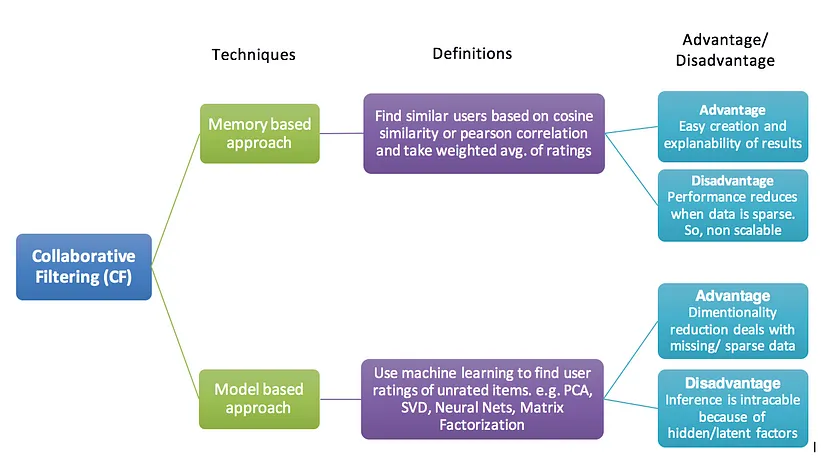

**Insight :** On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

Answer : Memory based and model based approaches

**Here, I am using Model based approach-Using matrix factorization to get embeddings and get insights about recommendations.**

# Section 4.1 : Using Matrix Factorization - User related user identified and get movie suggestions

In [ ]:
finaldf

,UserID,MovieID,Rating,Timestamp,MovieViewCount,MovieAvgRating,UserViewCount,UserAvgRating,Gender,Age,...,film-noir,horror,musical,mystery,other,romance,sci-fi,thriller,war,western
0,1,1193,5,978300760,1725,4.391,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,661,3,978302109,525,3.465,53,4.189,F,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,914,3,978301968,636,4.154,53,4.189,F,1,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,3408,4,978300275,1315,3.864,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2355,5,978824291,1703,3.854,53,4.189,F,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,373,2.794,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000205,6040,1094,5,956704887,1229,3.731,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1000206,6040,562,5,956704746,478,3.799,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000207,6040,1096,4,956715648,344,3.977,341,3.578,M,25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Format details of input data to CMFREC fit method**

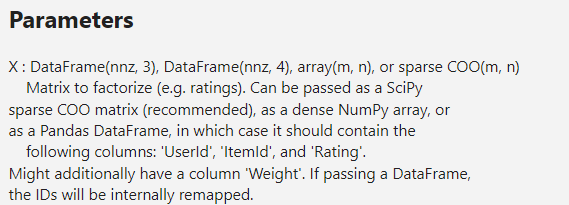

In [ ]:
def printModelPerformanceMetrics(model,actualMatrix):
  actualMatrix = actualMatrix.pivot(index = 'UserId', columns ='ItemId', values = 'Rating').fillna(0)
  actualMatrix = actualMatrix.astype(float)
  from sklearn.metrics import mean_squared_error as mse
  from sklearn.metrics import mean_absolute_percentage_error as mape
  r_hat = np.dot(model.A_, model.B_.T) + model.glob_mean_
  print('---------Model Performance Metrics-----------')
  print('')
  print('MSE Value:::::::'+str(mse(actualMatrix.values[actualMatrix > 0], r_hat[actualMatrix > 0])**0.5))
  print('MAPE Value::::::'+str(mape(actualMatrix.values[actualMatrix > 0], r_hat[actualMatrix > 0])))
  print('')
  print('---------End of Model Performance Metrics-----------')

In [ ]:
def getNRecommendedMoviesForUserUsingCollborativeFiltering(totalData,hyperparamKForFactorization,userMovieMatrix,queryUserId,RecommendationsCountRequired):
  from cmfrec import CMF
  cmfmodel = CMF(k=hyperparamKForFactorization, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
  cmfmodel.fit(userMovieMatrix)
  printModelPerformanceMetrics(cmfmodel,userMovieMatrix)
  recommendedMovieIds,predictedUserratingsForRecommendedMovies=cmfmodel.topN(user=queryUserId,n=RecommendationsCountRequired,output_score=True)
  recommendedMovieIdDataframe=totalData.loc[totalData.MovieID.isin(list(recommendedMovieIds))][['MovieID','Title','MovieViewCount','MovieAvgRating']].drop_duplicates(keep='first')
  UserEmbedding,MovieEmbedding=cmfmodel.A_, cmfmodel.B_
  return recommendedMovieIdDataframe,UserEmbedding,MovieEmbedding

In [ ]:
# Lib requires specific column names,so renamed columns
userMovieMatrix=finaldf[['UserID','MovieID','Rating']].copy()
userMovieMatrix.columns = ['UserId', 'ItemId', 'Rating']  
hyperparamKForFactorization=4
queryUserId='1'
RecommendationsCountRequired=5

In [ ]:
recommendedMovieIdDataframe,UserEmbedding,MovieEmbedding=getNRecommendedMoviesForUserUsingCollborativeFiltering(finaldf,hyperparamKForFactorization,userMovieMatrix,queryUserId,RecommendationsCountRequired)

---------Model Performance Metrics-----------

MSE Value:::::::1.4162766395744593
MAPE Value::::::0.41179340002557857

---------End of Model Performance Metrics-----------


**Insight: for userId - 1 watched movies like Close shave,star wars 4,Schindlers list.**

**Our recommender code suggested Slipper and The Rose,Grateful Dead,Wide Awake etc, which need to check similarity more to confirm whether these are good suggestions or not**

In [ ]:
recommendedMovieIdDataframe

,MovieID,Title,MovieViewCount,MovieAvgRating
6028,3612,"Slipper and the Rose, The",30,3.633
8724,1421,Grateful Dead,22,3.045
21780,1812,Wide Awake,44,3.477
112306,1493,Love and Other Catastrophes,17,3.294
184465,2776,"Marcello Mastroianni: I Remember Yes, I Remember",13,3.769


In [ ]:
UserEmbedding

array([[-0.12933134, -0.15189286,  0.07375468,  0.01435655],
       [-0.16539054, -0.11354104, -0.26231843, -0.2726446 ],
       [-0.12035376,  0.0132057 , -0.33116952,  0.12507795],
       ...,
       [ 0.00476626, -0.12225685, -0.07513777, -0.24390875],
       [ 0.01852678, -0.12579902, -0.16648194, -0.10056264],
       [ 0.41142398, -0.1040208 , -0.21599527, -0.20010932]],
      dtype=float32)

In [ ]:
MovieEmbedding

array([[ 0.6244838 , -4.462738  , -1.4788665 ,  0.6402331 ],
       [ 0.28633237, -1.309326  ,  2.2437916 ,  0.80183274],
       [-1.6430658 , -3.758575  ,  0.04637544, -1.5825236 ],
       ...,
       [ 1.0130836 , -0.55610514,  2.5456426 , -2.9544265 ],
       [-1.5860116 , -0.40994012, -1.1005744 , -0.7722787 ],
       [ 0.36862975, -0.4730357 , -0.20981833,  0.19164029]],
      dtype=float32)

# Section 4.2: User Embedding features are used to create user-user similarity to find similar users and get recommendations

**Cross check dimensions of components match with input matrix**

In [ ]:
userMovieMatrix.nunique()

UserId    6040
ItemId    3688
Rating       5
dtype: int64

In [ ]:
UserEmbedding.shape

(6040, 4)

In [ ]:
MovieEmbedding.shape

(3688, 4)

**User-User Similarity recommender code with User Embedding**

In [ ]:
userCols=['UserFeature'+str(itr) for itr in range(1,hyperparamKForFactorization+1)]
UserEmbeddingDf=pd.DataFrame(data=UserEmbedding,columns=userCols)
UserEmbeddingDf['UserID']=userMovieMatrix['UserId']
UserEmbeddingDf

,UserFeature1,UserFeature2,UserFeature3,UserFeature4,UserID
0,-0.129331,-0.151893,0.073755,0.014357,1
1,-0.165391,-0.113541,-0.262318,-0.272645,1
2,-0.120354,0.013206,-0.331170,0.125078,1
3,0.263918,-0.340280,-0.213928,-0.352070,1
4,0.440139,0.024906,-0.210620,-0.098705,1
...,...,...,...,...,...
6035,0.249428,-0.140230,-0.133167,-0.121135,44
6036,0.093933,-0.085397,-0.163153,-0.123577,44
6037,0.004766,-0.122257,-0.075138,-0.243909,44
6038,0.018527,-0.125799,-0.166482,-0.100563,44


In [ ]:
from sklearn.neighbors import NearestNeighbors
def getNSimilarUsersUsingNearestNeighborsAlgoWithCosineMetricWithUserEmbedding(UserEmbeddingDf,listOfColsToDesignSimilarity,queryUserId,RecommendationsCountRequired):
  # fitting the model
  nbrs = NearestNeighbors(n_neighbors=RecommendationsCountRequired+1, algorithm='brute',metric='cosine',n_jobs=-1).fit(UserEmbeddingDf[listOfColsToDesignSimilarity])
  distances, indices = nbrs.kneighbors(UserEmbeddingDf[listOfColsToDesignSimilarity])

  # preparing consolidated dataframe of results
  indicescolumns=['queryIndex']
  distanceValColumns=['selfDist']
  for itr in range(1,RecommendationsCountRequired+1):
    indicescolumns.append('NeighrIndex_'+str(itr))
    distanceValColumns.append('DistValOfNgbr_'+str(itr))
  resultantdf=pd.DataFrame(data=indices,columns=indicescolumns)
  resultantdf[distanceValColumns]=distances
  
  # filtering required neighbours from entire resultant dataframe
  reqIndex=UserEmbeddingDf.loc[(UserEmbeddingDf['UserID']==queryUserId)].index.values[0]
  neighbourindices=resultantdf.loc[(resultantdf['queryIndex']==reqIndex)][indicescolumns[1:]].values[0]
  return UserEmbeddingDf.iloc[neighbourindices]

In [ ]:
def getNRecommendedMoviesUsingSmilarUsers(similarusersdf,queryUserId,RecommendationsCountRequired):
  canBeRecommendedMoviesViewedBySimilarUsers=finaldf.loc[finaldf.UserID.isin(similarusersdf.loc[similarusersdf.UserID!=queryUserId]['UserID'].values)].sort_values(by='MovieAvgRating',ascending=False)['MovieID'].values
  canBeRecommendedMoviesViewedBySimilarUsers=np.unique(canBeRecommendedMoviesViewedBySimilarUsers)
  userwatchedMoviesList=finaldf.loc[(finaldf.UserID==queryUserId)].MovieID.values
  recommendableMoviesList=finaldf.loc[finaldf.MovieID.isin(canBeRecommendedMoviesViewedBySimilarUsers)&~(finaldf.MovieID.isin(userwatchedMoviesList))].MovieID.values
  return finaldf.loc[finaldf.MovieID.isin(recommendableMoviesList)].head(RecommendationsCountRequired)[['UserID','MovieID','Title','MovieViewCount','MovieAvgRating']].sort_values(by='MovieAvgRating',ascending=False)

In [ ]:
hyperparamKForFactorization=4
queryUserId='1'
RecommendationsCountRequired=5
colslist=['UserFeature1', 'UserFeature2', 'UserFeature3', 'UserFeature4']

In [ ]:
similarusersdf=getNSimilarUsersUsingNearestNeighborsAlgoWithCosineMetricWithUserEmbedding(UserEmbeddingDf,colslist,queryUserId,RecommendationsCountRequired)
similarusersdf

,UserFeature1,UserFeature2,UserFeature3,UserFeature4,UserID
4812,-0.190637,-0.232056,0.095032,0.003148,34
233,-0.180887,-0.252164,0.132749,0.022357,4
4510,-0.186978,-0.273501,0.120936,0.037748,33
155,-0.201995,-0.216312,0.086214,-0.002738,2
3839,-0.134405,-0.183035,0.063485,0.006820,28


In [ ]:
finaldf.loc[finaldf.UserID.isin(list(queryUserId)+list(similarusersdf.UserID.values))][['UserID','UserAvgRating','Gender','Age','Occupation']].drop_duplicates(keep='first')

,UserID,UserAvgRating,Gender,Age,Occupation
0,1,4.189,F,1,10
53,2,3.713,M,56,16
233,4,4.190,M,45,7
3838,28,3.757,F,25,1
4263,33,3.499,M,45,3
4654,34,3.866,F,18,0


In [ ]:
getNRecommendedMoviesUsingSmilarUsers(similarusersdf,queryUserId,RecommendationsCountRequired)

,UserID,MovieID,Title,MovieViewCount,MovieAvgRating
55,2,1537,Shall We Dance? (Shall We Dansu?),350,4.137
57,2,2194,"Untouchables, The",1127,4.008
54,2,3068,"Verdict, The",379,3.865
53,2,1357,Shine,548,3.807
56,2,647,Courage Under Fire,441,3.553


# Section 4.3: Movie Embedding features are used to create item-item similarity to find similar movies as recommendations

In [ ]:
hyperparamKForFactorization=4
QueryMovieID='1'
RecommendationsCountRequired=5
colslist=['MovieFeature1','MovieFeature2','MovieFeature3','MovieFeature4']

In [ ]:
itemCols=['MovieFeature'+str(itr) for itr in range(1,hyperparamKForFactorization+1)]
MovieEmbeddingDf=pd.DataFrame(data=MovieEmbedding,columns=itemCols)
MovieEmbeddingDf['MovieID']=userMovieMatrix['ItemId']
MovieEmbeddingDf

,MovieFeature1,MovieFeature2,MovieFeature3,MovieFeature4,MovieID
0,0.624484,-4.462738,-1.478866,0.640233,1193
1,0.286332,-1.309326,2.243792,0.801833,661
2,-1.643066,-3.758575,0.046375,-1.582524,914
3,-2.314583,-2.012928,-0.251120,-0.218708,3408
4,-1.297253,-2.538862,0.054499,0.130970,2355
...,...,...,...,...,...
3683,0.665909,-1.291723,-0.563544,0.196906,2881
3684,0.284313,0.772114,0.351664,0.011502,3684
3685,1.013084,-0.556105,2.545643,-2.954427,3686
3686,-1.586012,-0.409940,-1.100574,-0.772279,612


In [ ]:
from sklearn.neighbors import NearestNeighbors
def getNRecommendedMoviesUsingNearestNeighborsAlgoWithCosineMetricWithMovieEmbedding(MovieEmbeddingDf,listOfColsToDesignSimilarity,QueryMovieID,RecommendationsCountRequired):
  # fitting the model
  nbrs = NearestNeighbors(n_neighbors=RecommendationsCountRequired+1, algorithm='brute',metric='cosine',n_jobs=-1).fit(MovieEmbeddingDf[listOfColsToDesignSimilarity])
  distances, indices = nbrs.kneighbors(MovieEmbeddingDf[listOfColsToDesignSimilarity])

  # preparing consolidated dataframe of results
  indicescolumns=['queryIndex']
  distanceValColumns=['selfDist']
  for itr in range(1,RecommendationsCountRequired+1):
    indicescolumns.append('NeighrIndex_'+str(itr))
    distanceValColumns.append('DistValOfNgbr_'+str(itr))
  resultantdf=pd.DataFrame(data=indices,columns=indicescolumns)
  resultantdf[distanceValColumns]=distances

  # filtering required neighbours from entire resultant dataframe
  reqIndex=MovieEmbeddingDf.loc[(MovieEmbeddingDf['MovieID']==str(QueryMovieID))].index.values[0]
  neighbourindices=resultantdf.loc[(resultantdf['queryIndex']==reqIndex)][indicescolumns[1:]].values[0]
  return finaldf.loc[finaldf.MovieID.isin(list(MovieEmbeddingDf.iloc[neighbourindices].MovieID.values))][['MovieID','Title','MovieViewCount','MovieAvgRating']].drop_duplicates(keep='first')


In [ ]:
getNRecommendedMoviesUsingNearestNeighborsAlgoWithCosineMetricWithMovieEmbedding(MovieEmbeddingDf,colslist,QueryMovieID,RecommendationsCountRequired)

,MovieID,Title,MovieViewCount,MovieAvgRating
6,1287,Ben-Hur,704,4.111
50,3114,Toy Story 2,1585,4.219
91,3256,Patriot Games,1052,3.750
134,2717,Ghostbusters II,565,2.906
841,153,Batman Forever,777,2.642


# Section 5: Insights and Recommendations

Insight: Users of which age group have watched and rated the most number of movies? - 25 Age group : "25-34"

Insight: Users belonging to which profession have watched and rated the most movies? - Occupation 4: "college/grad student"

Recommendation: We need to add more movies on Comedy,Drama,Action for Age group 25-34.Like this we need to add movies as per genres intrested.


Insight : Most of the movies present in our dataset were released in which decade? - 90s decade

Insight: 56: "56+" group is watching less in all genres and movies of old decades are less in dataset - details are analysed.

Recommendation: We need to design new system which will convert black and movies to colour. Using that system we need to add colour based old movies, 
which will attract 56+ group and other groups as well

Insight: Most of the users in our dataset who’ve rated the movies are Male? - Yes

Insight: Most female users watched Comedy and Drama genre related movies.

Recommendation: We need to add more Comedy and drama movies to attract Female audiences more.

Insight:film-noir and documentary genre has highest average rating.

Recommendation: we need to analyse more Age group wise and gender wise with hypothesis testing to come to a conclusion.based on it 
we can take those genres and add more movies on that front.


Insight: Both Cosine similarity and Pearson correlation coefficient gave same result for item-item based recommendations

Recommendation: we can use anyone of them rather than both

Insight: There are lot of null values in data,we cannot replace with 0 in null value places as 0 is the worst case scenario here as scale is from 0-5.

Recommendation : We need to use centred cosine method to solve this. This normalizes data such that average value will be 0 making it as non-least value.So we can fill nan values as 0.This also solves easy rater and critic rater user values impact on all other ratings.




# Section 6: Questionnaire


question: Users of which age group have watched and rated the most number of movies? - 25 Age group : "25-34"

question: Users belonging to which profession have watched and rated the most movies? - Occupation 4: "college/grad student"

question: Most of the users in our dataset who’ve rated the movies are Male? - Yes

question: Most of the movies present in our dataset were released in which decade? - 90s decade

question: The movie with maximum no. of ratings is ___. - American Beauty

question: Pearson Correlation ranges between _ to _ whereas, Cosine Similarity belongs to the interval between _ to _.

Answer : Pearson Correlation : [-1,1] -1 refers perfect negative correlation and 1 refers perfect positive correlation

Cosine Similarity: [0,1] '0' refers vectors are perpendicular,dissimilar vectors where as '1' refers that vectors are aligned perfectly with 0 degrees between them-similar vectors.

question: Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

Birdcage, The ;Bulworth; Naked Gun: From the Files of Police Squad!, The; Happy Gilmore

question: On the basis of approach, Collaborative Filtering methods can be classified into _-based and _-based.

Answer : Memory based and model based approaches

Question: Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

MSE Value:::::::1.4162766395744593
MAPE Value::::::0.41179340002557857